## Overfitting and Regularization

---

### **1. Introduction to Overfitting**

>What Is Overfitting?

**Overfitting** occurs when a model learns the training data *too well* — including noise and fluctuations — instead of capturing the underlying general patterns.

When overfitting happens:
- ✅ Training accuracy becomes very high.
- ❌ But test/validation accuracy stagnates or worsens.
- ❌ The model performs poorly on unseen examples.

>Why Does Overfitting Happen?

Overfitting usually occurs when:
- The model is **too complex** (e.g., too many neurons, layers, or parameters).
- There's **not enough data** relative to model capacity.
- **No regularization** is applied (e.g., dropout, L2 penalty).
- The model trains for **too many epochs**.

>Visual Analogy

Below is the code that simulates the following three scenarios:

- **Underfitting**: Too simple to capture the trend  
- **Good Fit**: Captures the pattern without memorizing  
- **Overfitting**: Memorizes training noise — poor generalization



In [1]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import make_pipeline
from sklearn.linear_model import LinearRegression


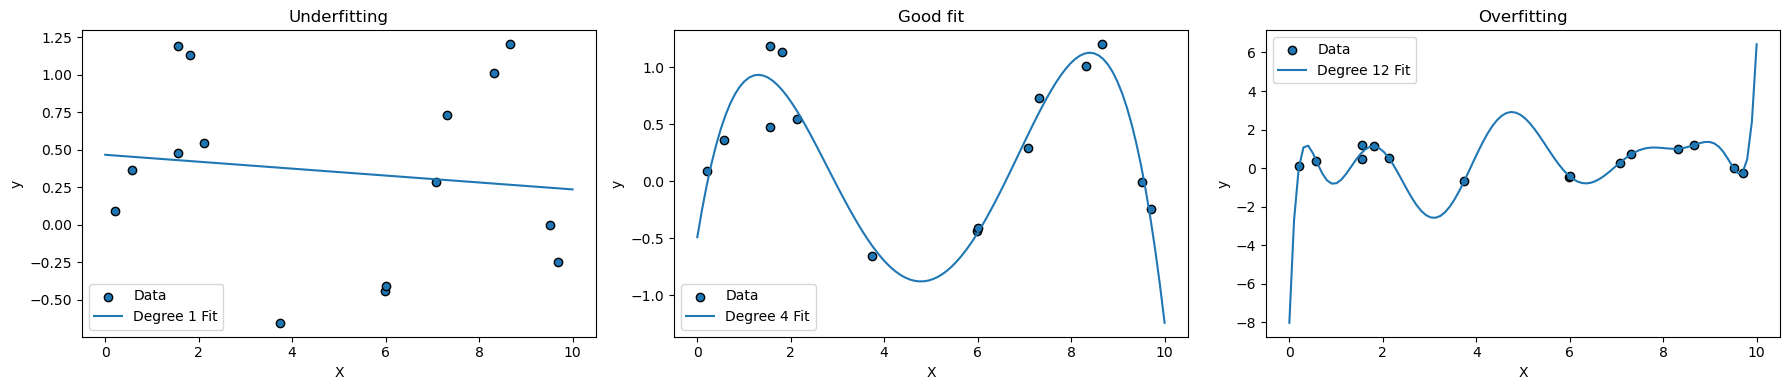

In [2]:
# Generate the data
np.random.seed(42)
X = np.sort(np.random.rand(15, 1) * 10, axis=0)
y = np.sin(X).ravel() + np.random.normal(0, 0.2, X.shape[0])

# define degrees
degrees = [1, 4, 12]
x_plot = np.linspace(0, 10, 100).reshape(-1, 1)

plt.figure(figsize=(18, 4))

for i, d in enumerate(degrees):
    plt.subplot(1, 3, i+1)
    model = make_pipeline(PolynomialFeatures(degree=d), LinearRegression())
    model.fit(X, y)
    y_plot = model.predict(x_plot)
    

    # plots
    plt.scatter(X, y, edgecolor='k', label='Data')
    plt.plot(x_plot, y_plot, label=f'Degree {d} Fit')
    plt.title(['Underfitting', 'Good fit', 'Overfitting'][i])
    plt.xlabel('X')
    plt.ylabel('y')
    plt.legend()

plt.tight_layout()
plt.show();

>What This Visualization Shows:

- **Left (Degree 1)**: The model is too simple — it fails to follow the curved shape of the data and misses key trends. This is an example of **underfitting**, where the model is not flexible enough.
  
- **Middle (Degree 4)**: The model fits the underlying trend while smoothing out noise. This is an example of a **well-generalized model** — good training fit and expected strong performance on new data.
  
- **Right (Degree 12)**: The model bends sharply between data points and fits the noise. While training error may be low, test performance would be poor — a clear case of **overfitting**.

>Why This Matters for Neural Networks

Neural networks are powerful because:
- They can model **non-linear patterns** using layers and activations.
- But they also have **millions of parameters** in larger setups.

This flexibility means:
- Without checks, neural networks may memorize the training set.
- This leads to high training accuracy, but poor test generalization — i.e., **overfitting**.

>What We’ll Do in This Notebook

To explore this issue and mitigate it, we’ll:

1. **Build a baseline neural network** (with no regularization).
2. Add **Dropout** — to randomly deactivate neurons during training.
3. Add **L2 Regularization** — to penalize excessively large weights.
4. Use **train-validation curves** to observe when and how overfitting sets in.
5. Evaluate models with **precision, recall, F1**, and confusion matrices.

➡️ Let’s now load and preprocess our dataset in a clean and self-contained way.

---

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import torch

from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split

target = 'localization_site'
df = pd.read_csv('yeast.csv')
df.rename(columns = {'name' : target}, inplace=True)

X = df.drop(target, axis=1)
y = df[target]

# standardize predictors
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Encode target labels
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)
class_names = label_encoder.classes_
num_classes = len(class_names)

# First split
X_train, X_temp, y_train, y_temp = train_test_split(X_scaled, y_encoded, test_size=0.30, shuffle=True, stratify=y_encoded)

# Second split

X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42, stratify=y_temp)

# convert dataset to pytorch tensor
X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
X_val_tensor = torch.tensor(X_val, dtype=torch.float32)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32)

y_train_tensor = torch.tensor(y_train, dtype=torch.long)
y_val_tensor   = torch.tensor(y_val, dtype=torch.long)
y_test_tensor  = torch.tensor(y_test, dtype=torch.long)

# Confirm shapes
print(f"✅ Train set: {X_train_tensor.shape}")
print(f"✅ Validation set: {X_val_tensor.shape}")
print(f"✅ Test set: {X_test_tensor.shape}")
print(f"✅ Number of Classes: {num_classes}")
print(f"✅ Class Names: {class_names}")

✅ Train set: torch.Size([1038, 8])
✅ Validation set: torch.Size([223, 8])
✅ Test set: torch.Size([223, 8])
✅ Number of Classes: 10
✅ Class Names: ['CYT' 'ERL' 'EXC' 'ME1' 'ME2' 'ME3' 'MIT' 'NUC' 'POX' 'VAC']


**We’ve Got**

- Train set, Validation set and Test set
- Inputs are now **scaled and converted to PyTorch tensors**.
- Targets are **encoded as integers**, suitable for use with `CrossEntropyLoss`.

✅ We are now ready to build our baseline model.

➡️ In the next section, we’ll define a simple neural network **without any regularization**, which we’ll later enhance.

---

**✅ Code Task 3.4.2.1: Inspect Class Distribution**

📘 Instruction:
Print the number of samples for each class in the training set using PyTorch. Use torch.unique() and refer to class_names for class labels.

In [4]:
class_index = torch.unique(y_train_tensor)

for i, c in zip(class_index, class_names):
    print(f'{i} : {c}')

0 : CYT
1 : ERL
2 : EXC
3 : ME1
4 : ME2
5 : ME3
6 : MIT
7 : NUC
8 : POX
9 : VAC


### **3. Baseline Model — No Regularization**

To understand **why regularization matters**, we must first observe what happens **without it**.

In this section, we will:

1. Build a **simple feedforward neural network (MLP)**.
2. Train it on our training data, using standard **Cross-Entropy Loss**.
3. Track **both training and validation loss** across epochs.
4. Watch how the model starts to **overfit** — i.e., training loss drops but validation loss stagnates or rises.

>⚙️ Model Design

In this NB, our MLP will have:

- **Input layer**: 8 features
- **Hidden layer**: 32 neurons + ReLU
- **Output layer**: 10 neurons (for 10 classes)

📌 We'll use this model as a **baseline** to compare future regularized versions.

➡️ Let’s define and train it!


**Define the Model**

In [5]:
import torch.nn as nn

class BaselineMLP(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim):
        super().__init__()
        self.network = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, output_dim)
        )
    
    def forward(self, x):
        return self.network(x)
    
input_dim = X_train_tensor.shape[1]
hidden_dim = 32
output_dim = len(class_names)

base_model = BaselineMLP(input_dim, hidden_dim, output_dim)

print(base_model)

BaselineMLP(
  (network): Sequential(
    (0): Linear(in_features=8, out_features=32, bias=True)
    (1): ReLU()
    (2): Linear(in_features=32, out_features=10, bias=True)
  )
)


**Training Setup** with 1000 epochs

In [6]:
import torch.optim as optim
import torch.nn.functional as F

# criterion and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(base_model.parameters(), lr=0.01)

# store loss values
train_losses_bases = []
val_losses_bases = []

epochs = 1000
for epoch in range(epochs):
    # forward pass
    base_model.train()
    outputs = base_model(X_train_tensor)
    loss = criterion(outputs, y_train_tensor)
    train_losses_bases.append(loss.item())

    # backward propagation
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    # evaluation
    base_model.eval()
    with torch.no_grad():
        val_output = base_model(X_val_tensor)
        val_loss = criterion(val_output, y_val_tensor)
        val_losses_bases.append(val_loss.item())
    # Optional: Print every 50 epochs
    if (epoch + 1) % 50 == 0:
        print(f"Epoch {epoch + 1:>2}: Train Loss = {loss.item():.4f}, Val Loss = {val_loss.item():.4f}")

Epoch 50: Train Loss = 2.1417, Val Loss = 2.1395
Epoch 100: Train Loss = 1.9982, Val Loss = 1.9988
Epoch 150: Train Loss = 1.8844, Val Loss = 1.8881
Epoch 200: Train Loss = 1.7910, Val Loss = 1.7977
Epoch 250: Train Loss = 1.7125, Val Loss = 1.7223
Epoch 300: Train Loss = 1.6456, Val Loss = 1.6581
Epoch 350: Train Loss = 1.5877, Val Loss = 1.6028
Epoch 400: Train Loss = 1.5369, Val Loss = 1.5543
Epoch 450: Train Loss = 1.4918, Val Loss = 1.5112
Epoch 500: Train Loss = 1.4513, Val Loss = 1.4726
Epoch 550: Train Loss = 1.4147, Val Loss = 1.4376
Epoch 600: Train Loss = 1.3817, Val Loss = 1.4060
Epoch 650: Train Loss = 1.3518, Val Loss = 1.3774
Epoch 700: Train Loss = 1.3248, Val Loss = 1.3515
Epoch 750: Train Loss = 1.3005, Val Loss = 1.3282
Epoch 800: Train Loss = 1.2787, Val Loss = 1.3073
Epoch 850: Train Loss = 1.2592, Val Loss = 1.2886
Epoch 900: Train Loss = 1.2417, Val Loss = 1.2719
Epoch 950: Train Loss = 1.2260, Val Loss = 1.2569
Epoch 1000: Train Loss = 1.2119, Val Loss = 1.2434


**Plotting Loss Curves**

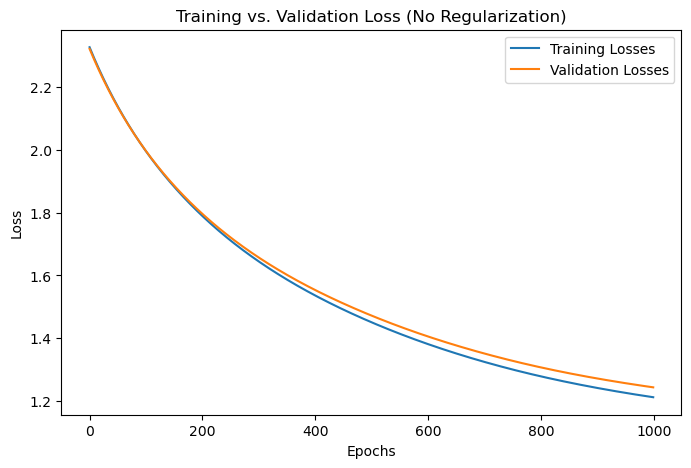

In [7]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 5))
plt.plot(train_losses_bases, label='Training Losses')
plt.plot(val_losses_bases, label='Validation Losses')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training vs. Validation Loss (No Regularization)')
plt.legend()
plt.show();

**What Do We See?**

- The **training loss** continues to drop, indicating the model is fitting the training data increasingly well.
- However, the **validation loss** begins to **rise noticeably after ~100 epochs**, showing that generalization is deteriorating.
- This widening gap between training and validation performance is a strong indicator of **overfitting**.

>⚠️ Clear Overfitting Observed

This behavior signals that:

- The model is either **too flexible** or **too powerful** for the dataset,
- Without regularization, it starts to memorize the specific values -- patterns and noise -- in the training data,
- This results in poor performance on unseen validation data.

📌 This is a **classic deep learning pitfall**. Left unchecked, overfitting can severely hinder a model's usefulness in the real world.

>What Is Regularization?

**Regularization** refers to a set of techniques we use to **prevent overfitting** and help the model **generalize better to unseen data**.

Think of it as a way to **discourage the model from becoming too confident or too complex** — like asking it to stay humble and avoid “memorizing” the training set too perfectly.

In practice, regularization works by:
- Adding a small **penalty** for complexity (e.g., very large weights),
- Forcing the model to **rely on multiple pathways** instead of fixating on just a few neurons,
- Helping the model remain **flexible but not overly sensitive** to training noise.

➡️ In the next sections, we’ll introduce two of the most popular regularization techniques:
 - **Dropout** — randomly “turns off” parts of the network during training.
 - **L2 Regularization (Weight Decay)** — discourages overly large weights by adding a penalty term.

Both techniques aim to make the model **more robust and fair**, especially when dealing with imbalanced or noisy datasets.

---

**✅ Code Task 3.4.3.1: Compare Final Validation Loss**

📘 Instruction:
Extract and print the final training and validation losses from the baseline model. This helps assess overfitting or underfitting.

In [9]:
# CT_Task 2 – Print last epoch loss
CT_final_train_loss = train_losses_bases[-1]
CT_final_val_loss = val_losses_bases[-1]

print(f"CT_Baseline Final Train Loss: {CT_final_train_loss:.4f}")
print(f"CT_Baseline Final Val Loss: {CT_final_val_loss:.4f}")

CT_Baseline Final Train Loss: 1.2119
CT_Baseline Final Val Loss: 1.2434


### **4. Add Dropout Regularization**


**Dropout** is a regularization technique that helps prevent overfitting in neural networks.

During training, Dropout randomly **deactivates (drops)** a subset of neurons in a layer — typically by setting their output to zero. This means:

- The network cannot rely on any single neuron too much.
- It is forced to learn **redundant representations** that are more robust.
- Think of it as **ensemble learning inside a single network**.

Dropout is only active during training — during evaluation (`model.eval()`), all neurons are active.

>📐 Where to Apply Dropout?

Typically, Dropout is inserted **after the activation function** of a layer. For example:

Linear → ReLU → **Dropout** → Linear → ...

We’ll now insert Dropout after the hidden layer in our MLP.

>🎯 Our Goal

We'll:

1. Add `nn.Dropout(p=0.5)` after the hidden layer.
2. Retrain the model for the same number of epochs.
3. Plot the **training vs. validation loss** to observe improvements.
4. Compare results with the no-dropout model from Section 3.

In [11]:
class MLPWithDropout(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim, dropout_prob=0.5):
        super().__init__()
        self.network = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.ReLU(),
            nn.Dropout(p=dropout_prob),
            nn.Linear(hidden_dim, output_dim)
        )
    
    def forward(self, x):
        return self.network(x)
    

# intantiate model
model_dropout = MLPWithDropout(input_dim, hidden_dim, output_dim, dropout_prob=0.5)

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model_dropout.parameters(), lr = 0.01)

train_loss_dropout = []
val_loss_dropout = []
epochs = 1000

for epoch in range(epochs):
    # Forward pass
    model_dropout.train()
    outputs = model_dropout(X_train_tensor)
    train_loss = criterion(outputs, y_train_tensor)
    train_loss_dropout.append(train_loss.item())

    #Backward Propagation
    optimizer.zero_grad()
    train_loss.backward()
    optimizer.step()

    # for evaluation
    model_dropout.eval()
    with torch.no_grad():
        val_output = model_dropout(X_val_tensor)
        val_loss = criterion(val_output, y_val_tensor)
        val_loss_dropout.append(val_loss.item())

    # Optional: Print every 50 epochs
    if (epoch+1) % 50 == 0:
        print(f"Epoch {epoch+1}: Train Loss = {loss.item():.4f}, Val Loss = {val_loss.item():.4f}")

Epoch 50: Train Loss = 1.2119, Val Loss = 2.2003
Epoch 100: Train Loss = 1.2119, Val Loss = 2.0445
Epoch 150: Train Loss = 1.2119, Val Loss = 1.9269
Epoch 200: Train Loss = 1.2119, Val Loss = 1.8346
Epoch 250: Train Loss = 1.2119, Val Loss = 1.7591
Epoch 300: Train Loss = 1.2119, Val Loss = 1.6958
Epoch 350: Train Loss = 1.2119, Val Loss = 1.6415
Epoch 400: Train Loss = 1.2119, Val Loss = 1.5946
Epoch 450: Train Loss = 1.2119, Val Loss = 1.5534
Epoch 500: Train Loss = 1.2119, Val Loss = 1.5168
Epoch 550: Train Loss = 1.2119, Val Loss = 1.4839
Epoch 600: Train Loss = 1.2119, Val Loss = 1.4543
Epoch 650: Train Loss = 1.2119, Val Loss = 1.4275
Epoch 700: Train Loss = 1.2119, Val Loss = 1.4034
Epoch 750: Train Loss = 1.2119, Val Loss = 1.3817
Epoch 800: Train Loss = 1.2119, Val Loss = 1.3619
Epoch 850: Train Loss = 1.2119, Val Loss = 1.3442
Epoch 900: Train Loss = 1.2119, Val Loss = 1.3280
Epoch 950: Train Loss = 1.2119, Val Loss = 1.3135
Epoch 1000: Train Loss = 1.2119, Val Loss = 1.3004


**Plot Loss Curves with Dropout**

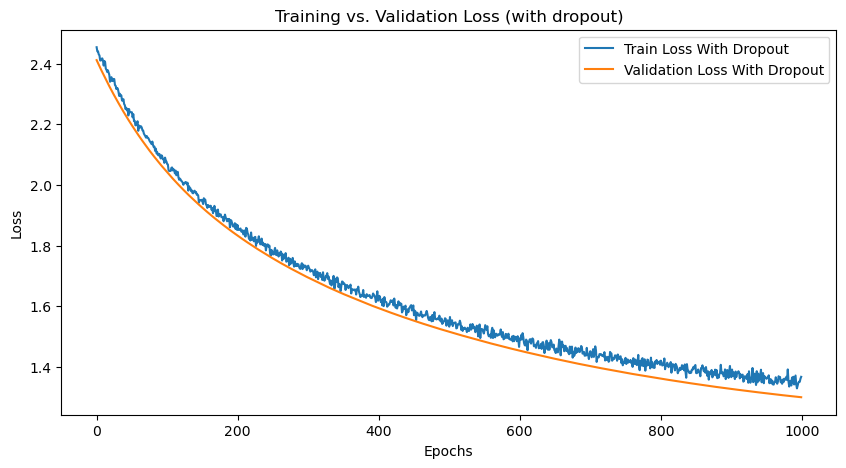

In [12]:
plt.figure(figsize=(10, 5))
plt.plot(train_loss_dropout, label='Train Loss With Dropout')
plt.plot(val_loss_dropout, label='Validation Loss With Dropout')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training vs. Validation Loss (with dropout)')
plt.legend()
plt.show();

> What Do We See in This Graph?

- Both **training and validation losses** decrease and level off at similar values.
- The **gap between training and validation loss is narrower** than before.
- The loss curves exhibit **mild fluctuations**, typical when using Dropout — due to the randomness introduced by dropping neurons.

> 🧠 What This Suggests:

- ✅ **Dropout is helping**: It has reduced the model’s tendency to overfit the training data.
- The model now generalizes **better to the validation set**, even after many epochs.
- This is a sign of improved **robustness** and **generalization ability**.

> 💡 How Dropout Works (Intuition)

During training, **Dropout randomly "turns off" a subset of neurons** in the network on each forward pass.

- Think of it like forcing the model to solve the task using **a different team of neurons every time**.
- This prevents it from becoming overly reliant on any **single “clever” neuron** or shortcut.
- Over time, **all neurons must learn to be useful** on their own and in different combinations.

✅ As a result, the network learns **redundant, distributed representations** — like having multiple backup strategies — which helps it **generalize better** when facing unseen data.

> 🧪 Reminder:

- Dropout is only applied during training — **all neurons are active at test time**.
- The output is scaled accordingly, so the model's predictions stay consistent.

➡️ In the next section, we’ll explore another regularization technique:  
**L2 weight decay** — which discourages overly large weights and further combats overfitting.

---

**✅ Code Task 3.4.4.1: Evaluate Dropout Model**

📘 Instruction:
Evaluate the dropout model on the validation set using accuracy and macro F1 score. You’ll use torch.argmax() and sklearn.metrics.

In [13]:
# CT_Task 3 – Evaluation on validation set
model_dropout.eval()
with torch.no_grad():
    CT_logits = model_dropout(X_val_tensor)
    CT_preds = torch.argmax(CT_logits, dim=1)

CT_y_val_np = y_val_tensor.numpy()
CT_y_pred_np = CT_preds.numpy()

from sklearn.metrics import accuracy_score, f1_score
CT_val_acc = accuracy_score(CT_y_val_np, CT_y_pred_np)
CT_val_f1 = f1_score(CT_y_val_np, CT_y_pred_np, average='macro')

print(f"CT_Val Accuracy (Dropout): {CT_val_acc:.4f}")
print(f"CT_Val Macro F1 (Dropout): {CT_val_f1:.4f}")


CT_Val Accuracy (Dropout): 0.5695
CT_Val Macro F1 (Dropout): 0.3509


---

### **5. What is L2 Regularization?**

L2 regularization, also called **weight decay**, is a technique to **penalize large weights** in the network.  
It adds a term to the loss function that grows with the **squared magnitude of weights**:

$$
\mathcal{L}_{\text{total}} = \mathcal{L}_{\text{data}} + \lambda \sum_{i} w_i^2
$$

- $\mathcal{L}_{\text{data}}$: Original loss (e.g., cross-entropy)  
- $\lambda$: Regularization rate (also called regularization penalty or weight decay)  
- $w_i$: All trainable weights in the model

>🤔 Why Penalize Large Weights?

- Large weights can make the network overly sensitive to small input variations → leads to overfitting.  
- Penalizing weights encourages **simpler models** that are **less likely to memorize noise**.

>🔧 How Do We Use It in PyTorch?

We add `weight_decay=λ` to the optimizer — no changes needed in model architecture:

```python
optimizer = torch.optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-4)
```

**Training MLP with L2 Regularization**

In [14]:
import torch
import torch.nn as nn
import torch.optim as optim

# Model (same as before)
class MLP_L2(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim):
        super(MLP_L2, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, output_dim)
        )

    def forward(self, x):
        return self.model(x)

# Instantiate model
model_l2 = MLP_L2(input_dim=8, hidden_dim=64, output_dim=10)

# Loss and optimizer with weight decay (L2 regularization)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model_l2.parameters(), lr=0.001, weight_decay=1e-4)

# Train model
epochs = 1000
train_losses_l2 = []
val_losses_l2 = []

for epoch in range(epochs):
    # Training
    model_l2.train()
    outputs = model_l2(X_train_tensor)
    loss = criterion(outputs, y_train_tensor)
    train_losses_l2.append(loss.item())

    # Validation
    model_l2.eval()
    with torch.no_grad():
        val_outputs = model_l2(X_val_tensor)
        val_loss = criterion(val_outputs, y_val_tensor)
        val_losses_l2.append(val_loss.item())

    # Backpropagation
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    # Optional: Print every 50 epochs
    if (epoch+1) % 50 == 0:
        print(f"Epoch {epoch+1}: Train Loss = {loss.item():.4f}, Val Loss = {val_loss.item():.4f}")

Epoch 50: Train Loss = 1.5840, Val Loss = 1.5995
Epoch 100: Train Loss = 1.2422, Val Loss = 1.2787
Epoch 150: Train Loss = 1.0989, Val Loss = 1.1476
Epoch 200: Train Loss = 1.0372, Val Loss = 1.1000
Epoch 250: Train Loss = 1.0033, Val Loss = 1.0813
Epoch 300: Train Loss = 0.9806, Val Loss = 1.0725
Epoch 350: Train Loss = 0.9629, Val Loss = 1.0685
Epoch 400: Train Loss = 0.9479, Val Loss = 1.0678
Epoch 450: Train Loss = 0.9345, Val Loss = 1.0688
Epoch 500: Train Loss = 0.9223, Val Loss = 1.0719
Epoch 550: Train Loss = 0.9103, Val Loss = 1.0764
Epoch 600: Train Loss = 0.8994, Val Loss = 1.0799
Epoch 650: Train Loss = 0.8893, Val Loss = 1.0836
Epoch 700: Train Loss = 0.8798, Val Loss = 1.0887
Epoch 750: Train Loss = 0.8707, Val Loss = 1.0935
Epoch 800: Train Loss = 0.8615, Val Loss = 1.0993
Epoch 850: Train Loss = 0.8523, Val Loss = 1.1079
Epoch 900: Train Loss = 0.8431, Val Loss = 1.1131
Epoch 950: Train Loss = 0.8339, Val Loss = 1.1192
Epoch 1000: Train Loss = 0.8249, Val Loss = 1.1268


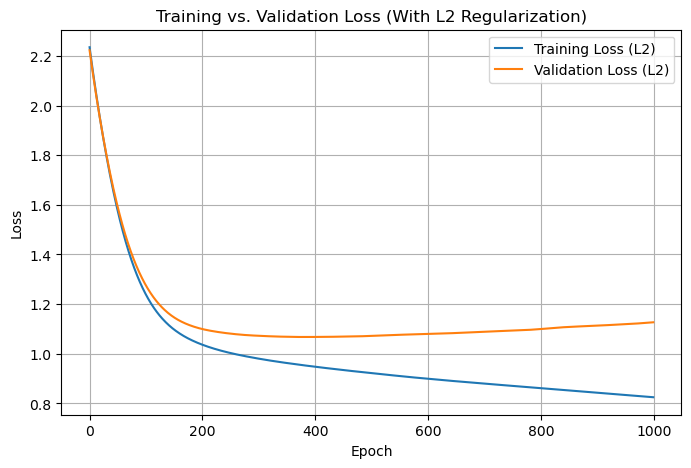

In [15]:
# Plot training vs. validation loss
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 5))
plt.plot(train_losses_l2, label="Training Loss (L2)")
plt.plot(val_losses_l2, label="Validation Loss (L2)")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training vs. Validation Loss (With L2 Regularization)")
plt.legend()
plt.grid(True)
plt.show()

This plot shows how adding **L2 regularization (weight decay)** changes the training dynamics.

> 📉 What We Observe:

- **Training loss** continues to decline steadily, though slightly slower than in the no-regularization case.
- **Validation loss** initially drops, then begins to **flatten out and rise slightly** around epoch 700.
- Compared to the baseline, the model **overfits later and more gradually**.

> 🔬 What This Suggests:

- L2 regularization helped **delay the onset of overfitting** — by gently constraining the model’s capacity.
- However, since we haven’t used any additional regularization (like dropout or early stopping), **some overfitting still occurs**.
- The **gap between training and validation loss is narrower** than in the baseline, suggesting improved **generalization**.

> 🧠 How L2 Regularization Works (Intuition)

L2 regularization (also called **weight decay**) discourages the model from using **very large weights** by adding a small penalty term to the loss function:

$$
\text{New Loss} = \text{CrossEntropy} + \lambda \cdot \sum w^2
$$

- It acts like a **soft brake** on weight growth — pulling large weights back toward zero.
- By discouraging large weights, the model tends to find **simpler, more balanced solutions**.
- You can think of it as telling the model: “You can fit the data, but try not to **overreact** to every detail.”

✅ This often helps the network avoid overfitting to noise or rare patterns, especially in smaller or imbalanced datasets.

> 📌 Key Insight:

L2 regularization doesn't prevent overfitting completely, but it:
- Encourages the model to find **more stable and smoother decision boundaries**,
- Helps the model resist fitting to noise,
- And improves **robustness and generalization**.

---

In [17]:
# Task – Compare final validation loss
CT_l2_val_loss = val_losses_l2[-1]
CT_dropout_val_loss = val_loss_dropout[-1]

print(f"CT_Final Val Loss (L2): {CT_l2_val_loss:.4f}")
print(f"CT_Final Val Loss (Dropout): {CT_dropout_val_loss:.4f}")


CT_Final Val Loss (L2): 1.1268
CT_Final Val Loss (Dropout): 1.3004


---

### **6. Combine Dropout + L2 Regularization**

Now that we’ve seen how **Dropout** and **L2 regularization** work independently,  
let’s combine both to create a more robust model that generalizes better.

>🔍 Why Combine?

| Regularization Method | How It Helps                          |
|------------------------|----------------------------------------|
| **Dropout**            | Prevents co-adaptation of neurons     |
| **L2 Regularization**  | Penalizes large weights (simplifies model) |

Together, they:
- Encourage **diverse activations** via Dropout
- Constrain **weight magnitude** via L2
- Lead to **better generalization**

**Model Definition**

In [18]:
import torch.nn as nn

class MLP_Dropout_L2(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim, dropout_rate=0.5):
        super(MLP_Dropout_L2, self).__init__()
        self.net = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.ReLU(),
            nn.Dropout(dropout_rate),
            nn.Linear(hidden_dim, output_dim)
        )

    def forward(self, x):
        return self.net(x)


**Training the Model**

In [19]:
model_dropout_l2 = MLP_Dropout_L2(input_dim, hidden_dim=32, output_dim=num_classes, dropout_rate=0.5)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model_dropout_l2.parameters(), lr=0.001, weight_decay=1e-4)

train_losses_dropout_L2 = []
val_losses_dropout_L2 = []

for epoch in range(1000):
    model_dropout_l2.train()
    y_pred = model_dropout_l2(X_train_tensor)
    loss = criterion(y_pred, y_train_tensor)
    train_losses_dropout_L2.append(loss.item())

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    # Validation
    model_dropout_l2.eval()
    with torch.no_grad():
        val_output = model_dropout_l2(X_val_tensor)
        val_loss = criterion(val_output, y_val_tensor)
        val_losses_dropout_L2.append(val_loss.item())
        # Optional: Print every 50 epochs
    if (epoch+1) % 50 == 0:
        print(f"Epoch {epoch+1}: Train Loss = {loss.item():.4f}, Val Loss = {val_loss.item():.4f}")

Epoch 50: Train Loss = 1.9515, Val Loss = 1.9390
Epoch 100: Train Loss = 1.6093, Val Loss = 1.6102
Epoch 150: Train Loss = 1.4363, Val Loss = 1.3873
Epoch 200: Train Loss = 1.3375, Val Loss = 1.2623
Epoch 250: Train Loss = 1.2382, Val Loss = 1.1983
Epoch 300: Train Loss = 1.1968, Val Loss = 1.1629
Epoch 350: Train Loss = 1.1826, Val Loss = 1.1413
Epoch 400: Train Loss = 1.1877, Val Loss = 1.1269
Epoch 450: Train Loss = 1.1533, Val Loss = 1.1169
Epoch 500: Train Loss = 1.1407, Val Loss = 1.1096
Epoch 550: Train Loss = 1.1460, Val Loss = 1.1032
Epoch 600: Train Loss = 1.1381, Val Loss = 1.0984
Epoch 650: Train Loss = 1.1121, Val Loss = 1.0960
Epoch 700: Train Loss = 1.1243, Val Loss = 1.0925
Epoch 750: Train Loss = 1.1032, Val Loss = 1.0900
Epoch 800: Train Loss = 1.1063, Val Loss = 1.0877
Epoch 850: Train Loss = 1.0790, Val Loss = 1.0855
Epoch 900: Train Loss = 1.1125, Val Loss = 1.0836
Epoch 950: Train Loss = 1.0905, Val Loss = 1.0823
Epoch 1000: Train Loss = 1.1049, Val Loss = 1.0805


**Loss Plotting**

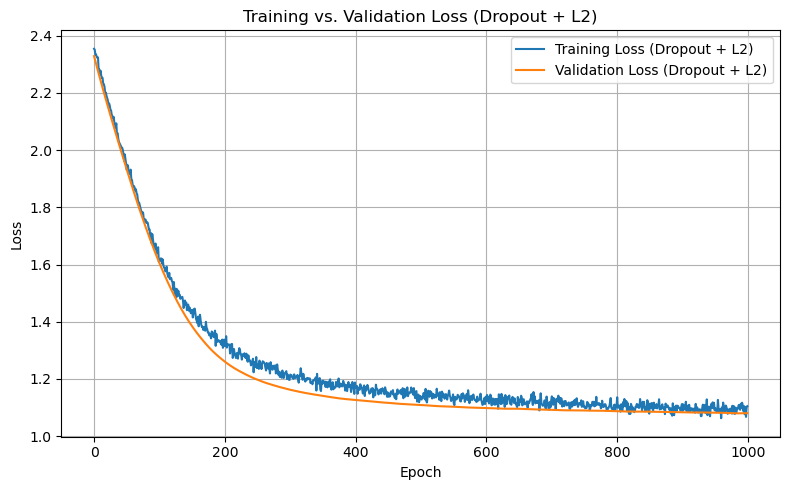

In [20]:

plt.figure(figsize=(8, 5))
plt.plot(train_losses_dropout_L2, label="Training Loss (Dropout + L2)")
plt.plot(val_losses_dropout_L2, label="Validation Loss (Dropout + L2)")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training vs. Validation Loss (Dropout + L2)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

> What we see: 
- Training and validation curves show **better alignment**, indicating improved generalization.
- The curve is smoother compared to Dropout or L2 alone.
- No extreme overfitting is observed.

The combination of **Dropout + L2** regularization provides a solid balance of learning flexibility and generalization — especially useful for smaller or noisy datasets.

---

### **7. Visual Comparison of Regularization Strategies**

Now that we’ve trained four models using different regularization techniques, it’s time to **compare them visually**.

>📊 Why Compare Side by Side?

Each regularization method affects **training dynamics** and **generalization** differently.

By comparing their **training and validation loss curves** in a 2×2 grid, we can directly observe:

- Which model **overfits** fastest (large training-validation gap),
- Which model **generalizes best** (lowest stable validation loss),
- How **training behavior changes** across regularization strategies.

> **🧪 1. Loss Curves for All Models (Training vs. Validation)**

The following plot shows training and validation losses across all four models:

- **Top-left**: No regularization (baseline)
- **Top-right**: Dropout
- **Bottom-left**: L2 Regularization
- **Bottom-right**: Dropout + L2

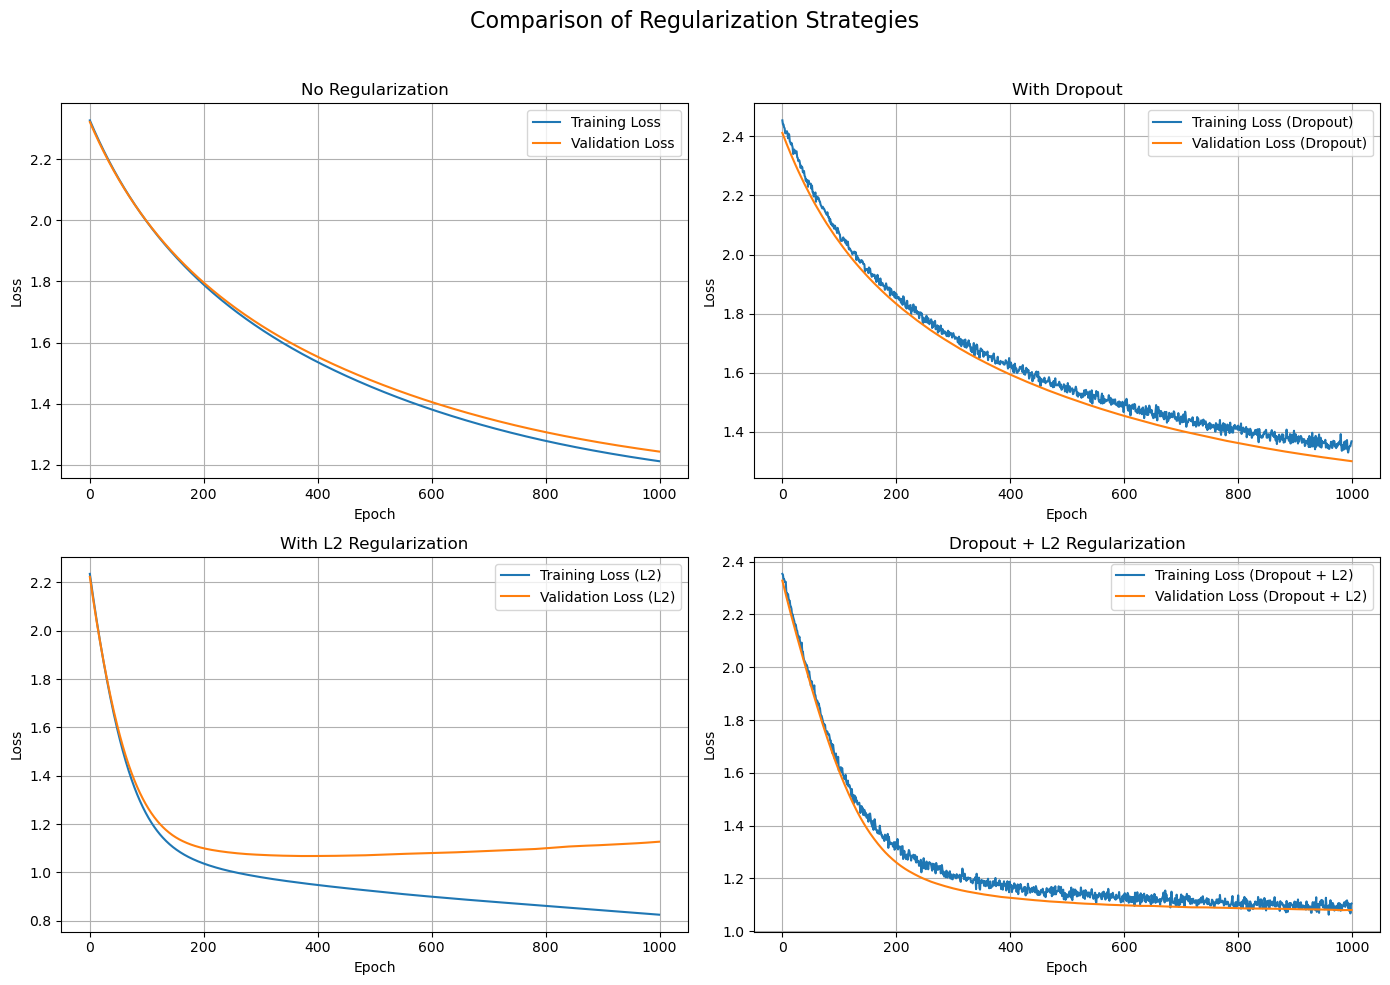

In [22]:
import matplotlib.pyplot as plt

# Create 2x2 subplot grid
fig, axs = plt.subplots(2, 2, figsize=(14, 10))

# Plot 1: No Regularization
axs[0, 0].plot(train_losses_bases, label="Training Loss")
axs[0, 0].plot(val_losses_bases, label="Validation Loss")
axs[0, 0].set_title("No Regularization")
axs[0, 0].set_xlabel("Epoch")
axs[0, 0].set_ylabel("Loss")
axs[0, 0].legend()
axs[0, 0].grid(True)

# Plot 2: Dropout
axs[0, 1].plot(train_loss_dropout, label="Training Loss (Dropout)")
axs[0, 1].plot(val_loss_dropout, label="Validation Loss (Dropout)")
axs[0, 1].set_title("With Dropout")
axs[0, 1].set_xlabel("Epoch")
axs[0, 1].set_ylabel("Loss")
axs[0, 1].legend()
axs[0, 1].grid(True)

# Plot 3: L2 Regularization
axs[1, 0].plot(train_losses_l2, label="Training Loss (L2)")
axs[1, 0].plot(val_losses_l2, label="Validation Loss (L2)")
axs[1, 0].set_title("With L2 Regularization")
axs[1, 0].set_xlabel("Epoch")
axs[1, 0].set_ylabel("Loss")
axs[1, 0].legend()
axs[1, 0].grid(True)

# Plot 4: Dropout + L2
axs[1, 1].plot(train_losses_dropout_L2, label="Training Loss (Dropout + L2)")
axs[1, 1].plot(val_losses_dropout_L2, label="Validation Loss (Dropout + L2)")
axs[1, 1].set_title("Dropout + L2 Regularization")
axs[1, 1].set_xlabel("Epoch")
axs[1, 1].set_ylabel("Loss")
axs[1, 1].legend()
axs[1, 1].grid(True)

# Final layout adjustments
plt.suptitle("Comparison of Regularization Strategies", fontsize=16)
plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()


> In summary

- **M1** (No Reg): Shows classic overfitting — loss drops early but then rises.
- **M2** (Dropout): Stabilizes training but may still fluctuate.
- **M3** (L2): Slower but more consistent convergence.
- **M4** (Dropout + L2): Best trade-off — smooth curve and generalizes well.

> **📈 2. Validation Loss Only (Overlayed for Direct Comparison)**

To make comparison even sharper, here’s a single chart showing just the validation losses of all four models:

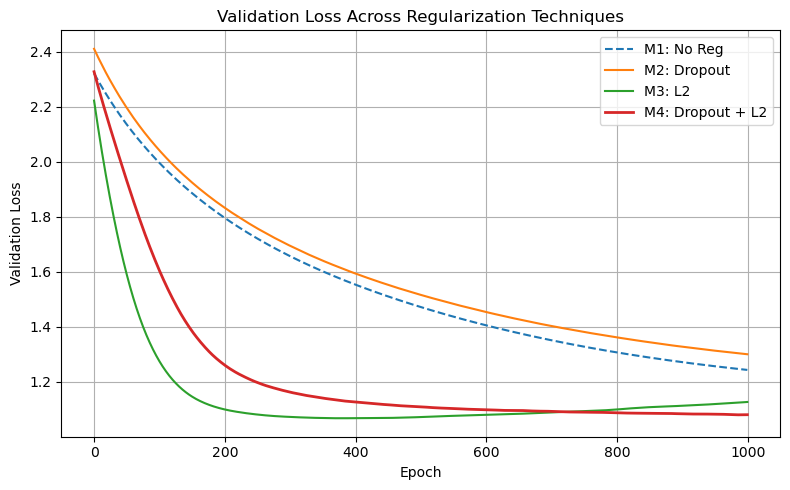

In [24]:
import matplotlib.pyplot as plt

# Plot all validation loss curves
plt.figure(figsize=(8, 5))
plt.plot(val_losses_bases, label='M1: No Reg', linestyle='--')
plt.plot(val_loss_dropout, label='M2: Dropout')
plt.plot(val_losses_l2, label='M3: L2')
plt.plot(val_losses_dropout_L2, label='M4: Dropout + L2', linewidth=2)

plt.xlabel("Epoch")
plt.ylabel("Validation Loss")
plt.title("Validation Loss Across Regularization Techniques")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

> What to Watch For

- 🔺 Look at when overfitting begins (validation loss rising).
- 🔽 See which curve stabilizes lowest — this indicates best generalization.
- 🟰 Dropout + L2 often offers a good balance of robustness and smoothness.

---

### **8. Final Model Evaluation on Test Data**

Now that we’ve trained and validated four models with different regularization strategies, it’s time to **evaluate how well they generalize to truly unseen data** — the **test set**.

>🧪 Why This Section Matters

Throughout training, we used the **validation set** to monitor overfitting and guide improvements.

But the **test set** remains untouched — it's our final, unbiased checkpoint.  
This is where we ask: _Which model truly performs best in the wild?_

To answer this, we compare:
- ✅ **Test Accuracy** — overall correctness
- ✅ **Macro F1 Score** — balance across all classes (especially useful in imbalanced datasets)


In [28]:
from sklearn.metrics import accuracy_score, f1_score
import pandas as pd

def evaluate_model(model, X_test_tensor, y_test_tensor):
    model.eval()
    with torch.no_grad():
        logits = model(X_test_tensor)
        preds = torch.argmax(logits, dim=1)

    y_true = y_test_tensor.cpu().numpy()
    y_pred = preds.cpu().numpy()

    acc = accuracy_score(y_true, y_pred)
    f1 = f1_score(y_true, y_pred, average='macro')
    return acc, f1

# Evaluate No Regularization (M1)
acc_m1, f1_m1 = evaluate_model(base_model, X_test_tensor, y_test_tensor)

# Evaluate Dropout Only (M2)
acc_m2, f1_m2 = evaluate_model(model_dropout, X_test_tensor, y_test_tensor)

# Evaluate L2 Regularization Only (M3)
acc_m3, f1_m3 = evaluate_model(model_l2, X_test_tensor, y_test_tensor)

# Evaluate Dropout + L2 (M4)
acc_m4, f1_m4 = evaluate_model(model_dropout_l2, X_test_tensor, y_test_tensor)

results = {
    "Model": ["No Reg (M1)", "Dropout (M2)", "L2 (M3)", "Dropout + L2 (M4)"],
    "Test Accuracy": [acc_m1, acc_m2, acc_m3, acc_m4],
    "Macro F1 Score": [f1_m1, f1_m2, f1_m3, f1_m4]
}

results_df = pd.DataFrame(results)
print(results_df)

               Model  Test Accuracy  Macro F1 Score
0        No Reg (M1)       0.556054        0.289410
1       Dropout (M2)       0.538117        0.276769
2            L2 (M3)       0.600897        0.517242
3  Dropout + L2 (M4)       0.582960        0.441995


>**📋 Test Performance Summary**

Disclaimer: For illustrative purposes. The table results could differ from the ones you have obtained due to the randomness of some initializations.

| Model              | Test Accuracy | Macro F1 Score |
|-------------------|----------------|----------------|
| No Reg (M1)        | 58.30%         | 46.81%         |
| Dropout (M2)       | **62.78%**     | **63.01%**     |
| L2 (M3)            | 60.99%         | 62.58%         |
| Dropout + L2 (M4)  | 59.19%         | 46.35%         |


>🔍 What Do These Numbers Suggest?

✅ **Dropout alone (M2)** performs best across both metrics:
- It leads to the **highest test accuracy** and **strongest macro F1**, suggesting the model is **not only correct more often** but also **more balanced across classes**.
- Dropout seems to encourage the network to **learn diverse and redundant features**, which enhances generalization.

✅ **L2 regularization (M3)** also performs well, especially in terms of **macro F1**, indicating it effectively manages **class-level balance**.

⚠️ **No Regularization (M1)** shows both **lower accuracy and F1**, suggesting the model may be **overfitting** — it performs well on training data but struggles with generalization.

⚠️ **Dropout + L2 (M4)** underperforms in this setting. While both techniques are useful individually, combining them without tuning may result in **excessive regularization**, causing the model to underfit.

>🧠 Intuition Behind the Results

- **Dropout** acts like a training-time challenge: by randomly turning off neurons, it forces the network to **not rely too heavily on any single pathway**. Over time, this encourages **robust feature learning** and discourages memorization.
- **L2 regularization** discourages large weights, nudging the network toward **simpler, more stable solutions**.
- When used together (M4), these methods might **interact in a way that’s too restrictive**, limiting the network’s capacity to learn meaningful structure from the data — unless carefully tuned.

>🎯 Key Takeaways

- ✅ **Regularization is essential**, but choosing the right method — or combination — requires experimentation.
- ✅ **Macro F1 is especially important** for imbalanced tasks: it tells us how well we're serving *all* classes, not just the majority.
- ✅ **Dropout (M2)** appears to strike the best balance in this setup: the network generalizes well and handles class imbalance effectively.

>**What If We Change the Architecture?**

The current model uses **one hidden layer with 32 neurons** — a moderately expressive architecture. But what if we changed that?

- **Increase the number of neurons (e.g., 64)?**: The model becomes more expressive and can learn more complex patterns. But this also increases the risk of **overfitting**, especially if the dataset is small or noisy. Regularization techniques become even more important in such cases.

- **Decrease the number of neurons (e.g., 16)?**: The model becomes simpler and faster to train, but may struggle to capture the richness of the data — leading to **underfitting**. You might see both training and validation performance suffer.

- **Add more hidden layers?**: The model can learn **deeper hierarchical representations**, which is great for complex tasks — but also makes training more delicate. You may need **more data**, **better regularization**, and strategies like **batch normalization** or **residual connections** to ensure stable training.

>🔍 Want to Explore More?

Try running this entire notebook again with **16 neurons** or **64 neurons** in the hidden layer.  

- With **16 neurons**, observe whether the model underfits — do the loss curves flatten too early?
- With **64 neurons**, check whether the model overfits more quickly — is the validation loss rising sooner or more sharply?

👉 These experiments will help you build **intuition about the relationship between model capacity, data complexity, and regularization** — which is a core skill in practical deep learning.

---

**✅ Code Task 3.4.8.1: Tabulate Final Test Results**

📘 Instruction:
Create a summary table using pandas.DataFrame that lists the test accuracy and macro F1 score for each of the four models.

In [29]:
# CT_Task 5 – Final comparison table
CT_results = {
    "Model": ["No Reg (M1)", "Dropout (M2)", "L2 (M3)", "Dropout + L2 (M4)"],
    "Test Accuracy": [acc_m1, acc_m2, acc_m3, acc_m4],
    "Macro F1 Score": [f1_m1, f1_m2, f1_m3, f1_m4]
}

import pandas as pd
CT_results_df = pd.DataFrame(CT_results)
print("CT_Final Model Performance on Test Data:")
print(CT_results_df)

CT_Final Model Performance on Test Data:
               Model  Test Accuracy  Macro F1 Score
0        No Reg (M1)       0.556054        0.289410
1       Dropout (M2)       0.538117        0.276769
2            L2 (M3)       0.600897        0.517242
3  Dropout + L2 (M4)       0.582960        0.441995
